<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/New_SVIBDN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, Model,load_model
from keras.optimizers import gradient_descent_v2 
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [2]:
!unzip -qq images.zip

In [3]:
!unzip -qq labels.zip

In [2]:
from PIL import Image
from numpy import *
images_folder= "images/*.jpg"
labels_folder = "labels/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  class_label=[]
  label = []
  files = glob.glob (images_folder)
  for myFile in files[:8000]:
      image_name=os.path.split(myFile)[1]
      class_label.append(float(image_name[0]))
      image = array(Image.open(myFile))
      label_image = array(Image.open(labels_folder+image_name))
      label.append (label_image)
      total_img.append (image)
  total_img = np.array(total_img)
  label = np.array(label)
  class_label=np.array(class_label) 
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2],label.shape[3]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
  #np.save('class_labels', class_label)
  #np.save('total-images',total_img)
  #np.save('label-images',label)
  return class_label,label,total_img

In [3]:
class_labels,total_labels,total_images=data_preprocessing(images_folder,labels_folder)

In [6]:
total_images.shape

(8000, 224, 224, 3)

In [7]:
total_labels.shape

(8000, 224, 224, 3)

In [8]:
class_labels.shape

(8000,)

In [4]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [5]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [6]:
def decoder_network(X):
    #x_input = layers.Input(shape=(147))
    #x = keras.layers.Reshape([7,7,3])(dX)
    x = layers.Conv2DTranspose(2048, (3, 3), strides=2, activation="relu", padding="same")(X)
    x = layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="sigmoid", padding="same")(x)
    output = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="sigmoid", padding="same")(x)
    #model = Model(inputs=X, outputs=output, name='decoder_network')
    return output


In [7]:
def ResNet50():
    #X_input = keras.Input(shape=(224, 224, 3))
    X_input = layers.Input(shape=(224, 224, 3))
    #X = data_augmentation(X_input)
    #X = layers.Rescaling(1./255)(X)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    #7*7*2048
    output1=decoder_network(X)
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
    output2 = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs=X_input, outputs=[output1,output2] , name='ResNet50')
    #return output1,output2
    return model

In [8]:
model= ResNet50()
#keras.utils.plot_model(model, show_shapes=True)

In [9]:
loss1=tf.keras.losses.MeanSquaredError()
loss2="binary_crossentropy"
model.compile(keras.optimizers.Adam(learning_rate=1e-3),loss = [loss1,loss2],)

In [10]:
class_label=class_labels[:7000]
x_train = total_images[:7000].astype(np.float32)/ 255.0
y_train=total_labels[:7000].astype(np.float32)/ 255.0
y_train = ( y_train,class_label)

In [16]:
unique, counts = np.unique(class_label, return_counts=True)

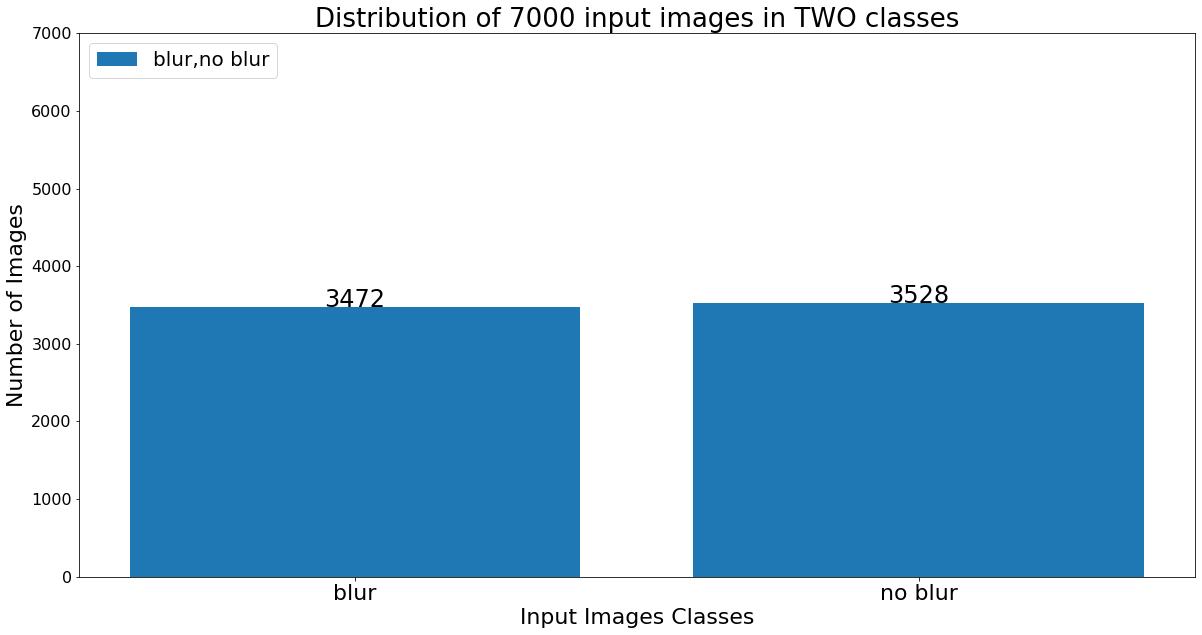

In [17]:
import matplotlib.pyplot as plt
def addlabels(x,y):
	for i in range(len(x)):
		plt.text(i,y[i],y[i],fontsize=24, ha='center')
if __name__ == '__main__':
	# creating data on which bar chart will be plot
	x = ['blur','no blur']
	y = [counts[0],counts[1]]
plt.figure(figsize=(20,10))
plt.bar(x, y,label='blur,no blur')
addlabels(x, y)
plt.title(f"Distribution of {(class_label.shape)[0]} input images in TWO classes",fontsize=26)
plt.xlabel('Input Images Classes',fontsize=22)
plt.ylabel('Number of Images',fontsize=22)
plt.yticks(np.arange(0, 8000,1000),fontsize=16)
plt.xticks(fontsize=22)
plt.gca().legend(prop={'size': 20},loc='upper left',fontsize=20)
plt.show()

In [11]:
history = model.fit(x_train,[y_train[0],y_train[1]], epochs=60,batch_size=20, validation_split=0.2, shuffle=True)
model.save('new_model.h5')

Epoch 1/60
280/280 [==============================] - 86s 278ms/step - loss: 1.5338 - conv2d_transpose_7_loss: 0.0933 - fc3_loss: 1.4405 - val_loss: 0.7711 - val_conv2d_transpose_7_loss: 0.0778 - val_fc3_loss: 0.6933
Epoch 2/60
280/280 [==============================] - 76s 271ms/step - loss: 0.6837 - conv2d_transpose_7_loss: 0.0780 - fc3_loss: 0.6057 - val_loss: 1.6685 - val_conv2d_transpose_7_loss: 0.0774 - val_fc3_loss: 1.5911
Epoch 3/60
280/280 [==============================] - 76s 270ms/step - loss: 0.3973 - conv2d_transpose_7_loss: 0.0778 - fc3_loss: 0.3194 - val_loss: 1.7588 - val_conv2d_transpose_7_loss: 0.0773 - val_fc3_loss: 1.6815
Epoch 4/60
280/280 [==============================] - 76s 270ms/step - loss: 0.2762 - conv2d_transpose_7_loss: 0.0778 - fc3_loss: 0.1984 - val_loss: 1.0516 - val_conv2d_transpose_7_loss: 0.0773 - val_fc3_loss: 0.9743
Epoch 5/60
280/280 [==============================] - 76s 270ms/step - loss: 0.2950 - conv2d_transpose_7_loss: 0.0778 - fc3_loss: 0.

In [12]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'conv2d_transpose_7_loss', 'fc3_loss', 'val_loss', 'val_conv2d_transpose_7_loss', 'val_fc3_loss'])


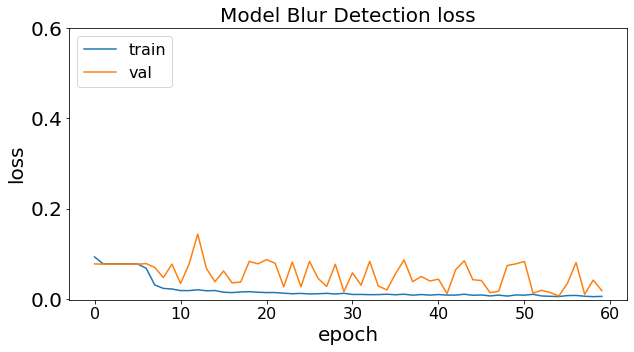

In [13]:
plt.figure(figsize=(10,5))
plt.plot(history.history['conv2d_transpose_7_loss'])
plt.plot(history.history['val_conv2d_transpose_7_loss'])
plt.title('Model Blur Detection loss',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.yticks(np.arange(0,0.8, 0.2),fontsize=20)
plt.xticks(fontsize=16)
plt.legend(['train', 'val'], loc='upper left',fontsize=16)
plt.show()

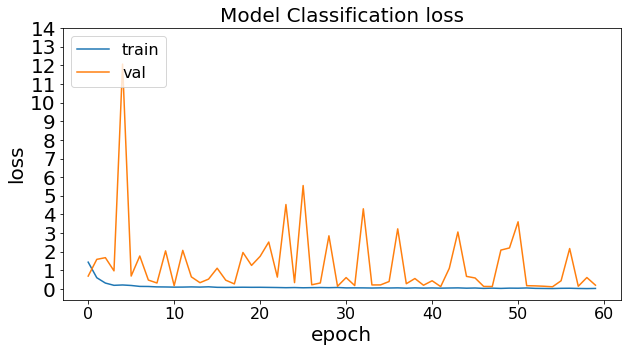

In [19]:
plt.figure(figsize=(10,5))
plt.plot(history.history['fc3_loss'])
plt.plot(history.history['val_fc3_loss'])
plt.title('Model Classification loss',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.yticks(np.arange(0,15,1),fontsize=20)
plt.xticks(fontsize=16)
plt.legend(['train', 'val'], loc='upper left',fontsize=16)
plt.show()

In [20]:
#evaluation images
eval_images=total_images[7000:]
eval_labels=total_labels[7000:]
eval_class_label=class_labels[7000:]

In [21]:
from keras.models import load_model
from PIL import Image
#images = np.load('test-blurry-images.npy')
images = eval_images
model = load_model("new_model.h5")
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [22]:
len(predictions)

1000

In [23]:
y_pred_class=[]
for i in range(len(predictions)):
  predicted_class=(((predictions[i])[1])[0])[0]
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  y_pred_class.append(predicted_class)

## Confusion Matrix

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
conf_m = confusion_matrix(eval_class_label, y_pred_class)
conf_m

array([[471,  53],
       [  8, 468]])

In [25]:
report = classification_report(eval_class_label, y_pred_class)
print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94       524
         1.0       0.90      0.98      0.94       476

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



## Intersection over Union

In [26]:
def get_iou_score(predictions,eval_labels):
  iou_scores=[]
  for i in range(len(predictions)):
    true_label = eval_labels[i]
    y_pred_label= ((((predictions[i])[0])[0])*255.0).astype(np.uint8)
    intersection = np.logical_and(true_label, y_pred_label)
    union = np.logical_or(true_label, y_pred_label)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)
  return mean(iou_scores)

In [27]:
iou_score = get_iou_score(predictions,eval_labels)

In [28]:
print('Averaged Intersection over Union IOU for Blur Detection: ',iou_score )

Averaged Intersection over Union IOU for Blur Detection:  0.354463244231536


In [29]:
from statistics import mean
mse_classification=[]
mse_blurDetection=[]
bce_classification=[]
kld_blurDetection=[]
kl = tf.keras.losses.KLDivergence()
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#bce(y_true, y_pred).numpy()
#kl(y_true, y_pred).numpy()
for i in range((images.shape)[0]):
  true_img_class=eval_class_label[i]
  img_pred_class=(((predictions[i])[1])[0])[0]
  true_img_label = eval_labels[i].astype(np.float32)/ 255.0
  img_pred_label= ((predictions[i])[0])[0]
  #mse classification
  mse_classification.append((img_pred_class- true_img_class)**2)
  #mse blur detection
  sb= np. subtract(img_pred_label, true_img_label)
  sq= np. square(sb)
  mseBd = sq.mean()
  mse_blurDetection.append(mseBd)
  #bce classification 
  bce_classification.append(bce([true_img_class],[img_pred_class]).numpy())
  kld_blurDetection.append(kl(true_img_label,img_pred_label).numpy())
MSE_C=mean(mse_classification)
MSE_BD=mean(mse_blurDetection)
BCE_C=mean(bce_classification)
KLD_BD=mean(kld_blurDetection)
print(f" MSE for Model Classification: {MSE_C}")
print(f" MSE for Model Blur area detection: {MSE_BD}")
print(f" BCE for Model Classification: {BCE_C}")
print(f" KLD for Model Blur area detection: {KLD_BD}")

 MSE for Model Classification: 0.04092779664520741
 MSE for Model Blur area detection: 0.01964927278459072
 BCE for Model Classification: 0.5453231930732727
 KLD for Model Blur area detection: 0.14031510055065155


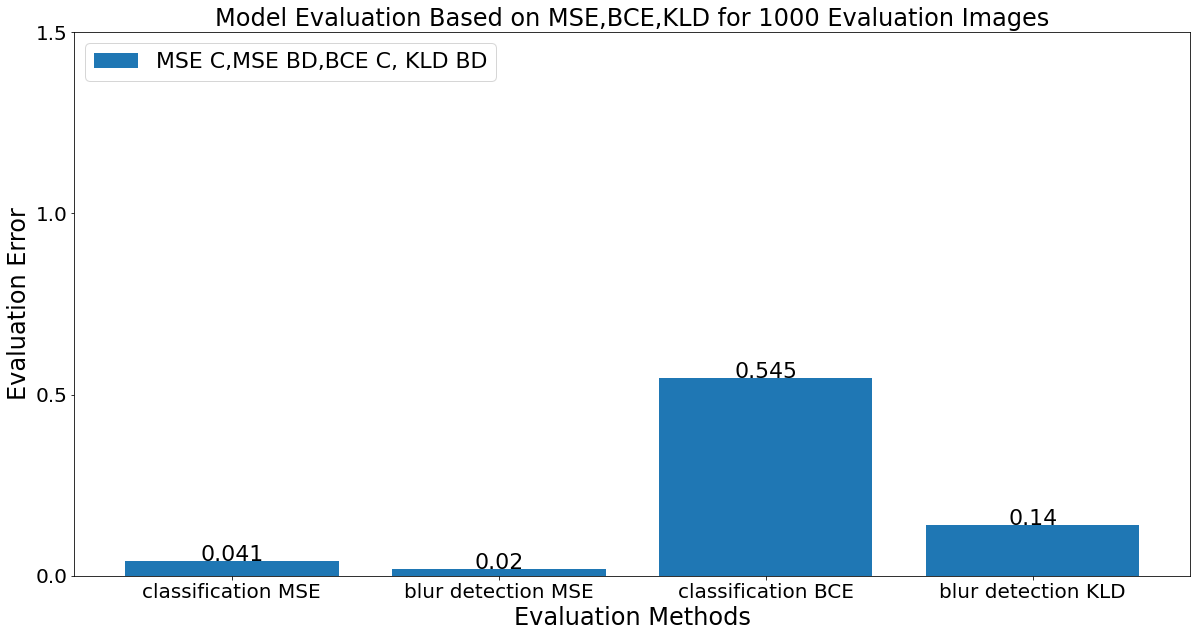

In [30]:
import matplotlib.pyplot as plt
def addlabels(x,y):
	for i in range(len(x)):
		plt.text(i,y[i],y[i],fontsize=22, ha='center')

if __name__ == '__main__':
	# creating data on which bar chart will be plot
	x = ['classification MSE','blur detection MSE','classification BCE','blur detection KLD']
	y = [MSE_C,MSE_BD,BCE_C,abs (KLD_BD)]
	y= np.around(y,decimals=3)
 #[MSE_C,MSE_BD,BCE_C,abs (KLD_BD)]
plt.figure(figsize=(20,10))
plt.bar(x, y,label='MSE C,MSE BD,BCE C, KLD BD')
addlabels(x, y)
plt.title(f"Model Evaluation Based on MSE,BCE,KLD for {(images.shape)[0]} Evaluation Images",fontsize=24)
plt.xlabel('Evaluation Methods',fontsize=24)
plt.ylabel('Evaluation Error',fontsize=24)
plt.yticks(np.arange(0,2,0.5),fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().legend(prop={'size': 22},loc='upper left')
plt.show()


predicted class vs true class


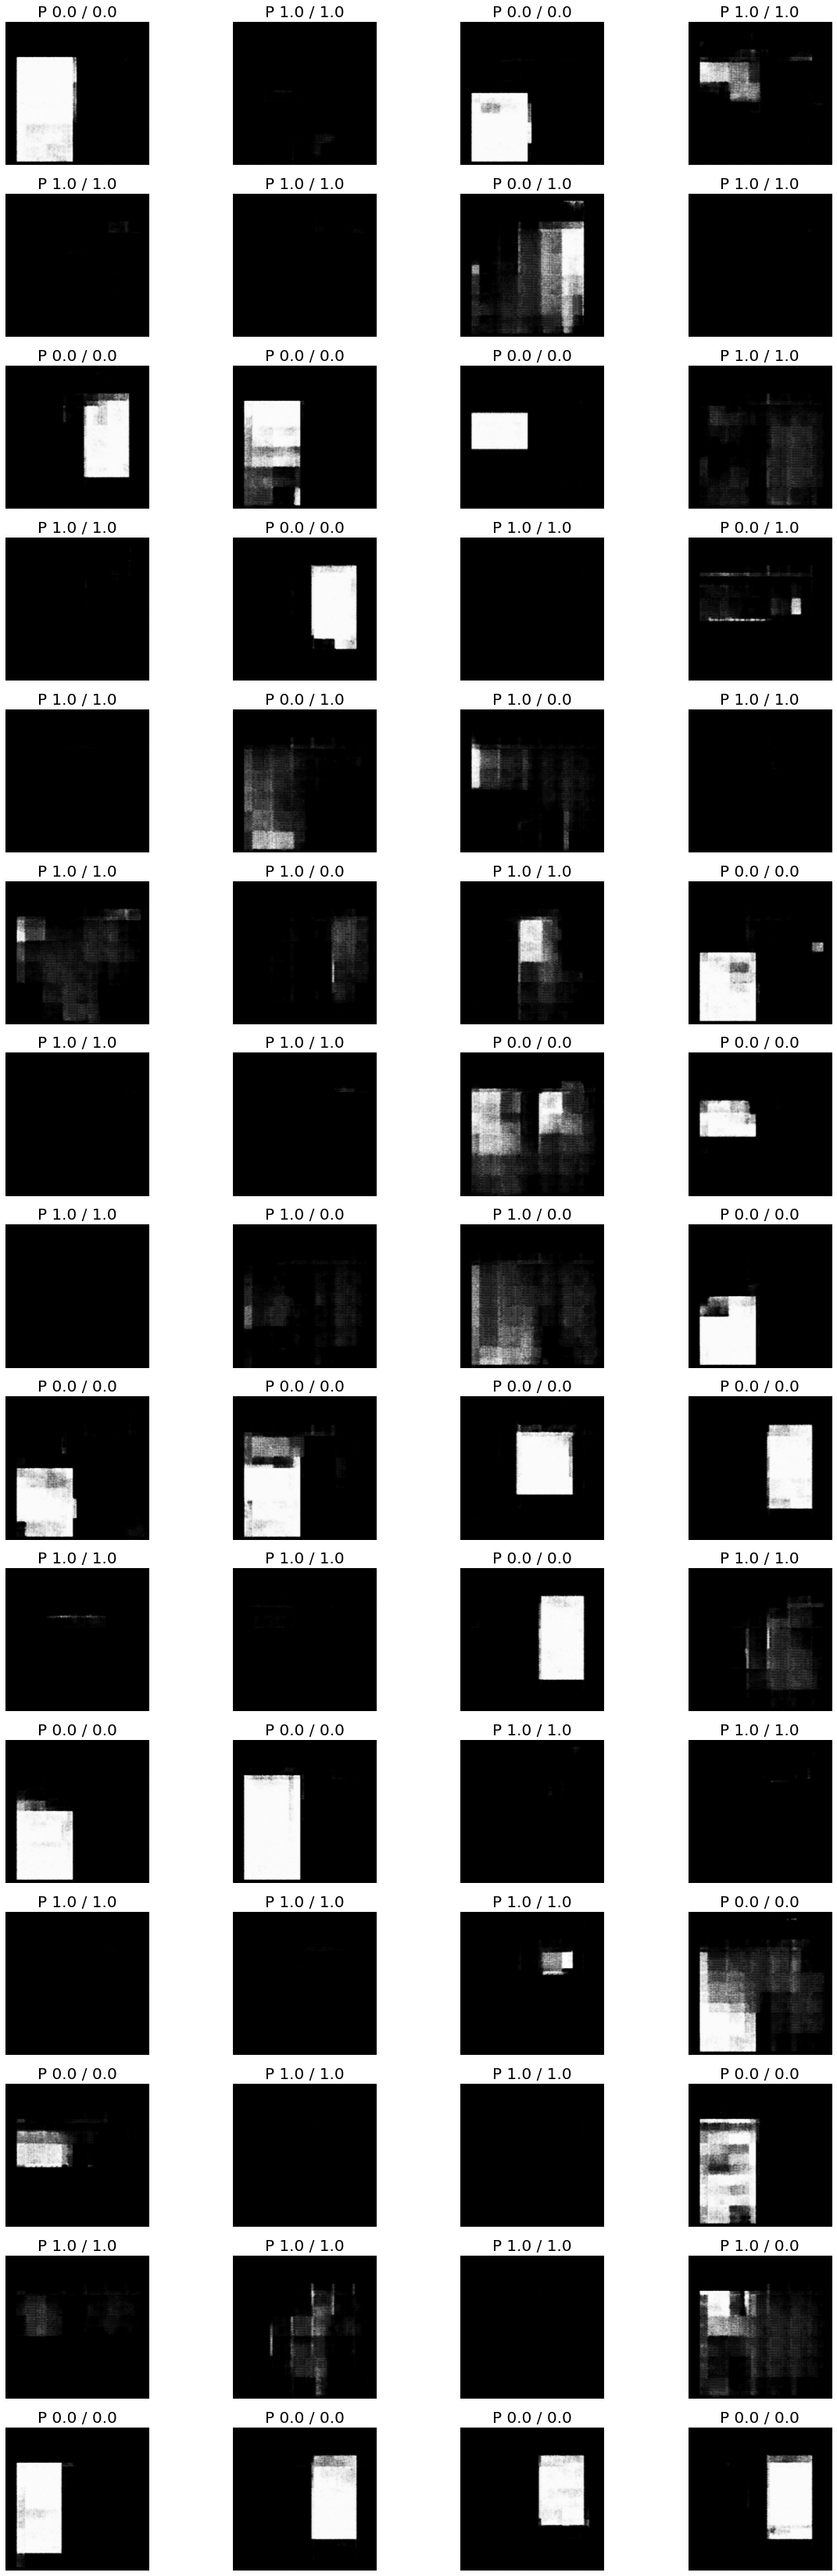

In [31]:

columns = 4
rows = 15
print("predicted class vs true class")
fig = plt.figure(figsize=(20,60))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(((((predictions[i])[0])[0])*255.0).astype(np.uint8))
  predicted_class=(((predictions[i])[1])[0])[0]
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  plt.title(f"P {predicted_class} / {eval_class_label[i]}",fontsize=20)
  plt.axis("off")
plt.show()

predicted class vs true class


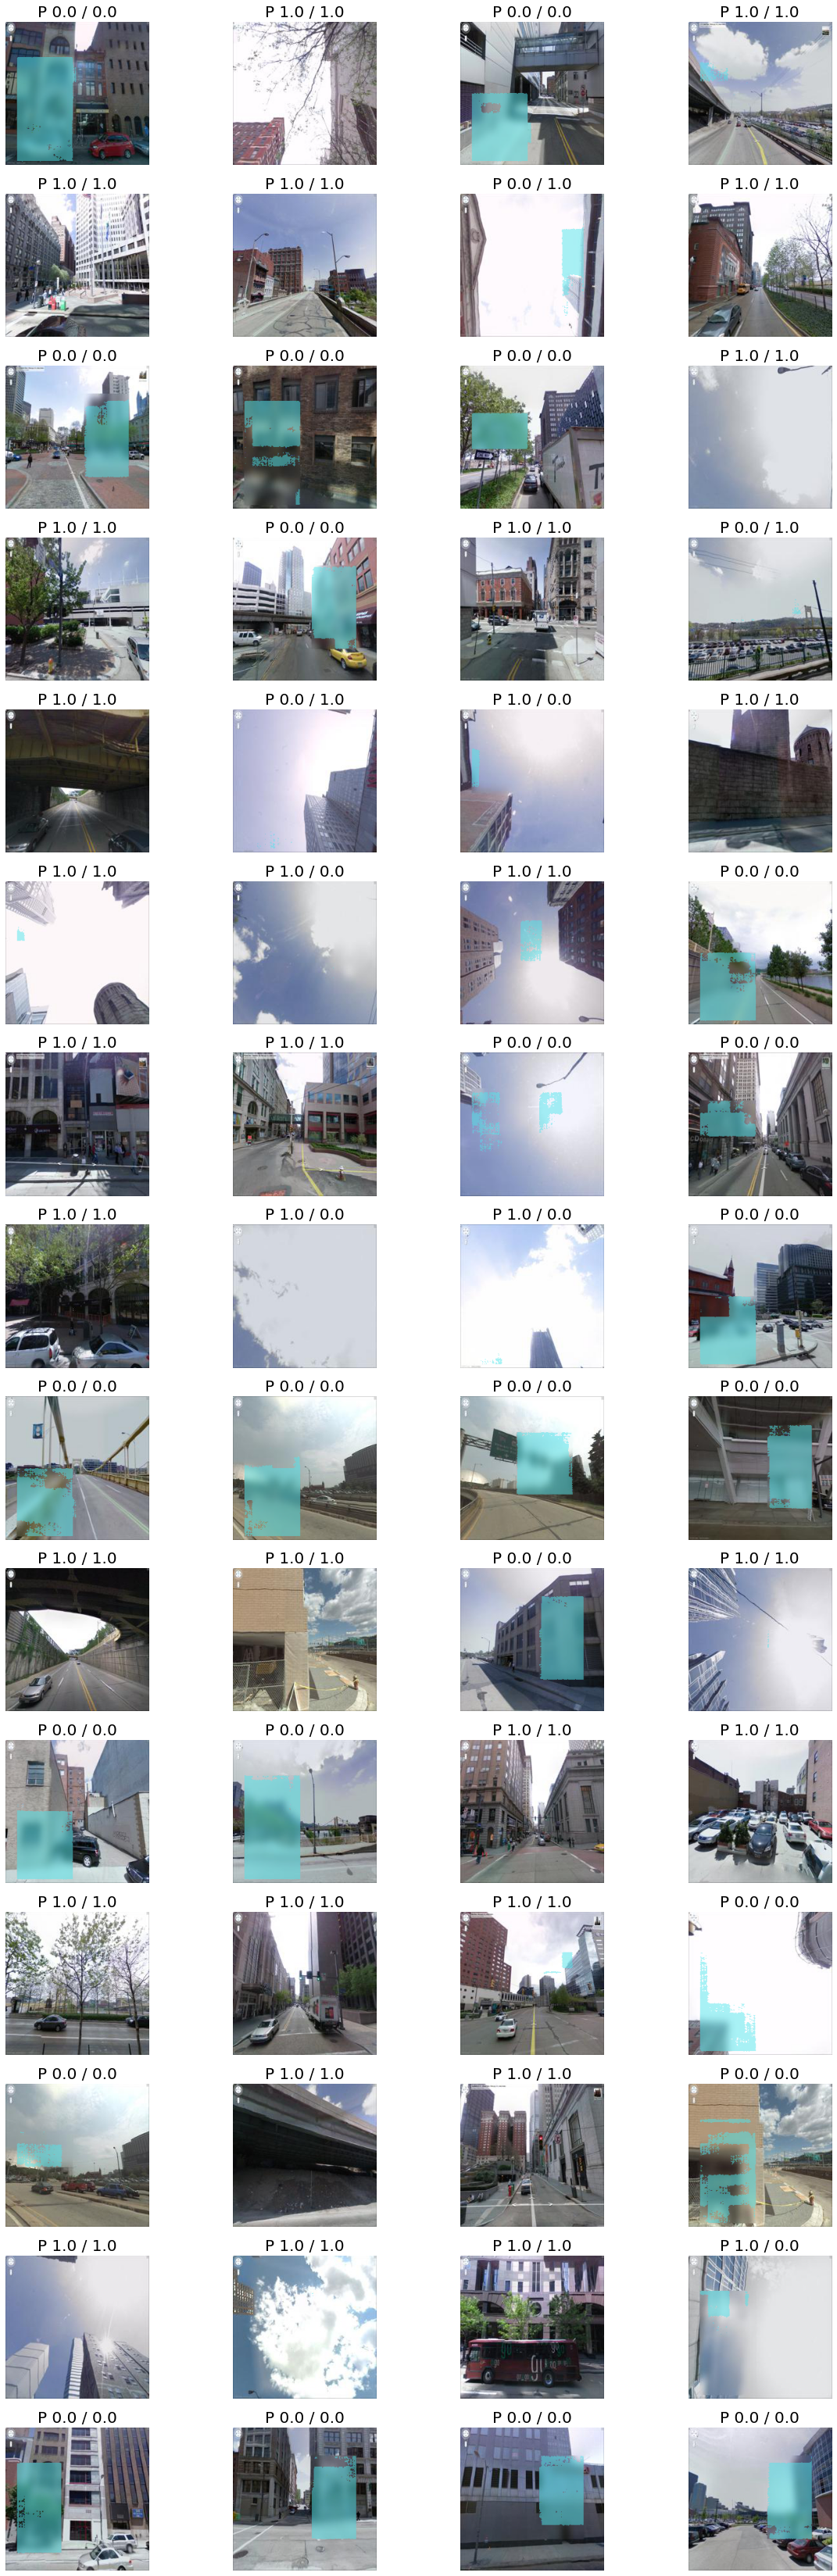

In [32]:
fig = plt.figure(figsize=(20,60))
columns = 4
rows = 15
print("predicted class vs true class")
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  mask=((((predictions[i])[0])[0])*255.0).astype(np.uint8)
  blackFrame = np.zeros((224,224, 3), dtype = "uint8")
  whiteFrame = 255 * np.ones((224,224,3), np.uint8)
  #label_img = Image.fromarray(label_img)
  mask = np.where(mask>=210,whiteFrame,blackFrame)
  img= images[i]
  cyan = np.full_like(img,(80, 229, 235))
  blend = 0.5
  img_cyan = cv2.addWeighted(img, blend, cyan, 1-blend, 0)
  mask = np.where(mask>=165,img_cyan,img)
  #mask =cv2.cvtColor(mask , cv2.COLOR_BGR2RGB)
  plt.imshow(mask,cmap='binary')
  #mask = Image.fromarray(mask)
  predicted_class=(((predictions[i])[1])[0])[0]
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  plt.title(f"P {predicted_class} / {eval_class_label[i]}",fontsize=20)
  plt.axis("off")
plt.show()

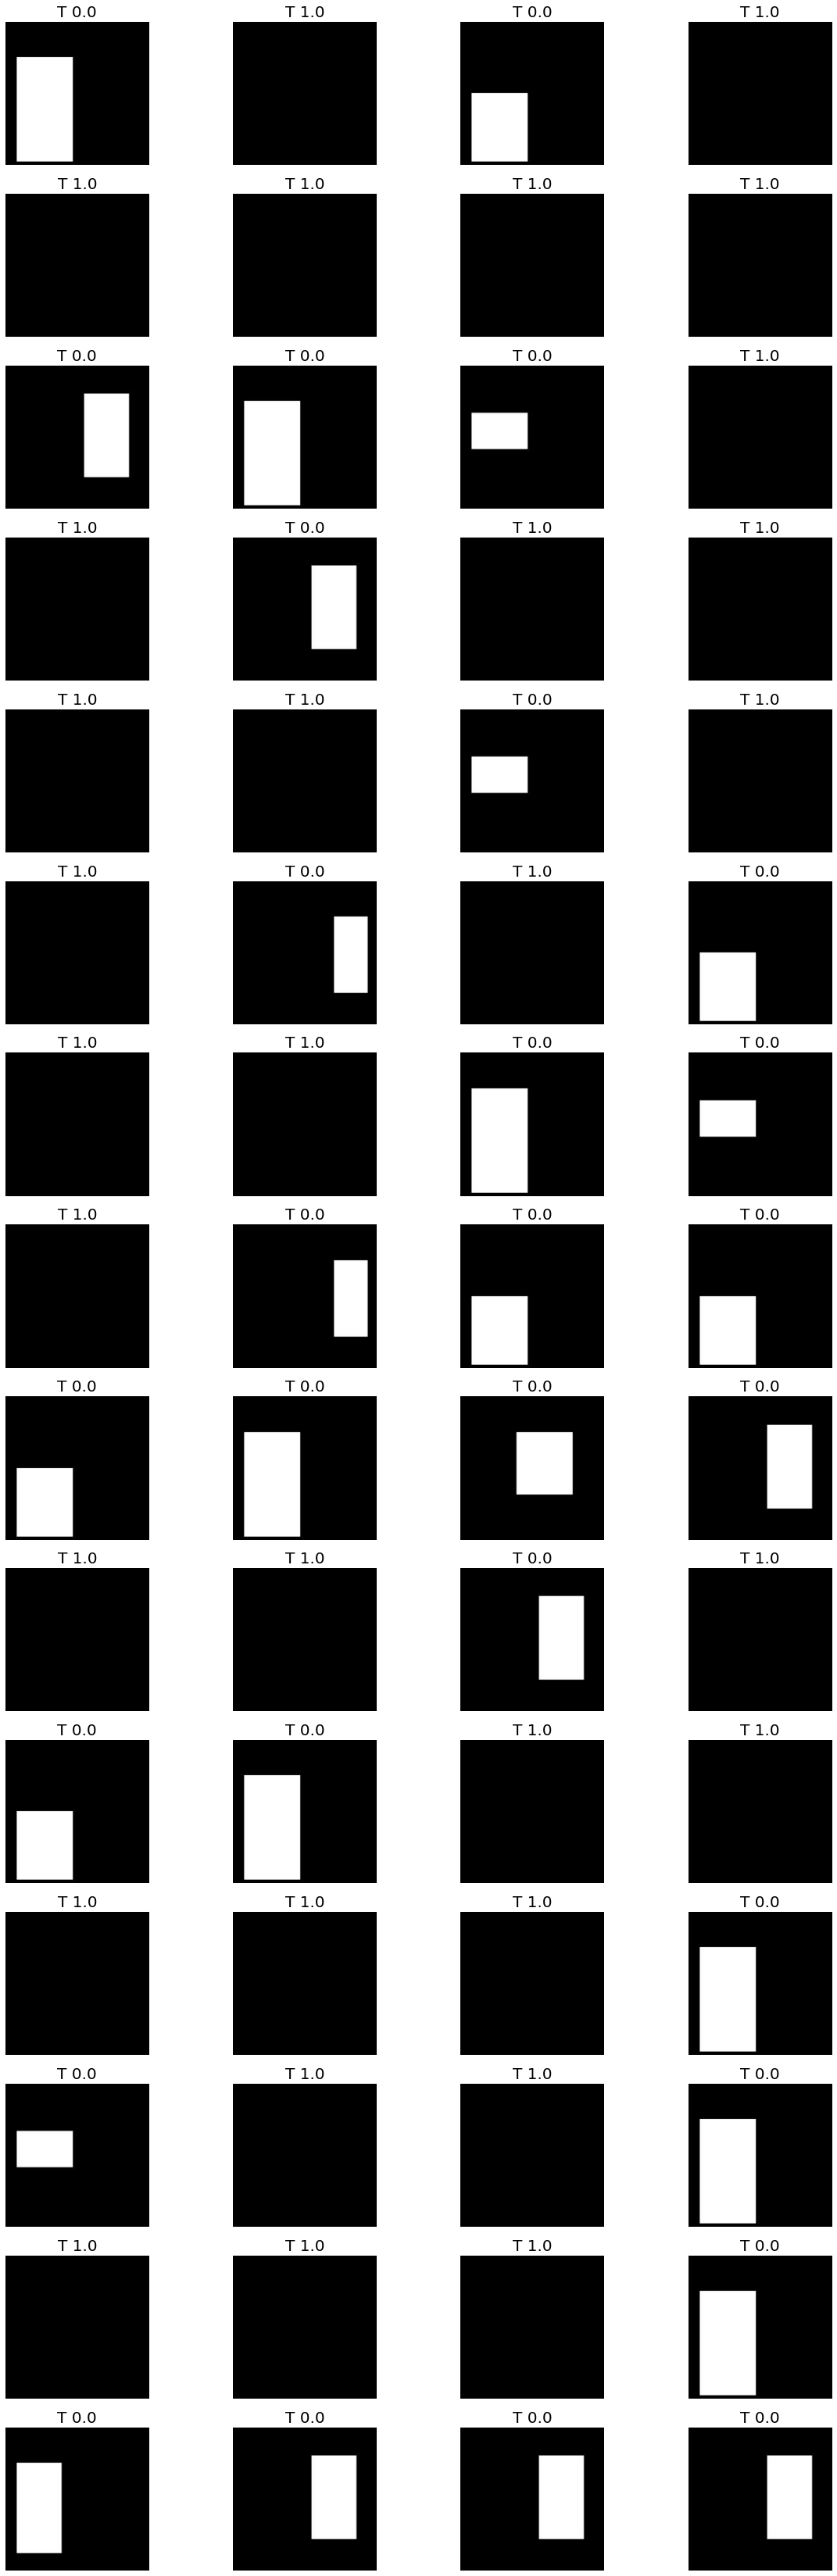

In [33]:
fig = plt.figure(figsize=(20,60))
columns = 4
rows = 15
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(eval_labels[i],cmap='binary')
  plt.title(f"T {eval_class_label[i]}",fontsize=20)
  plt.axis("off")
plt.show()

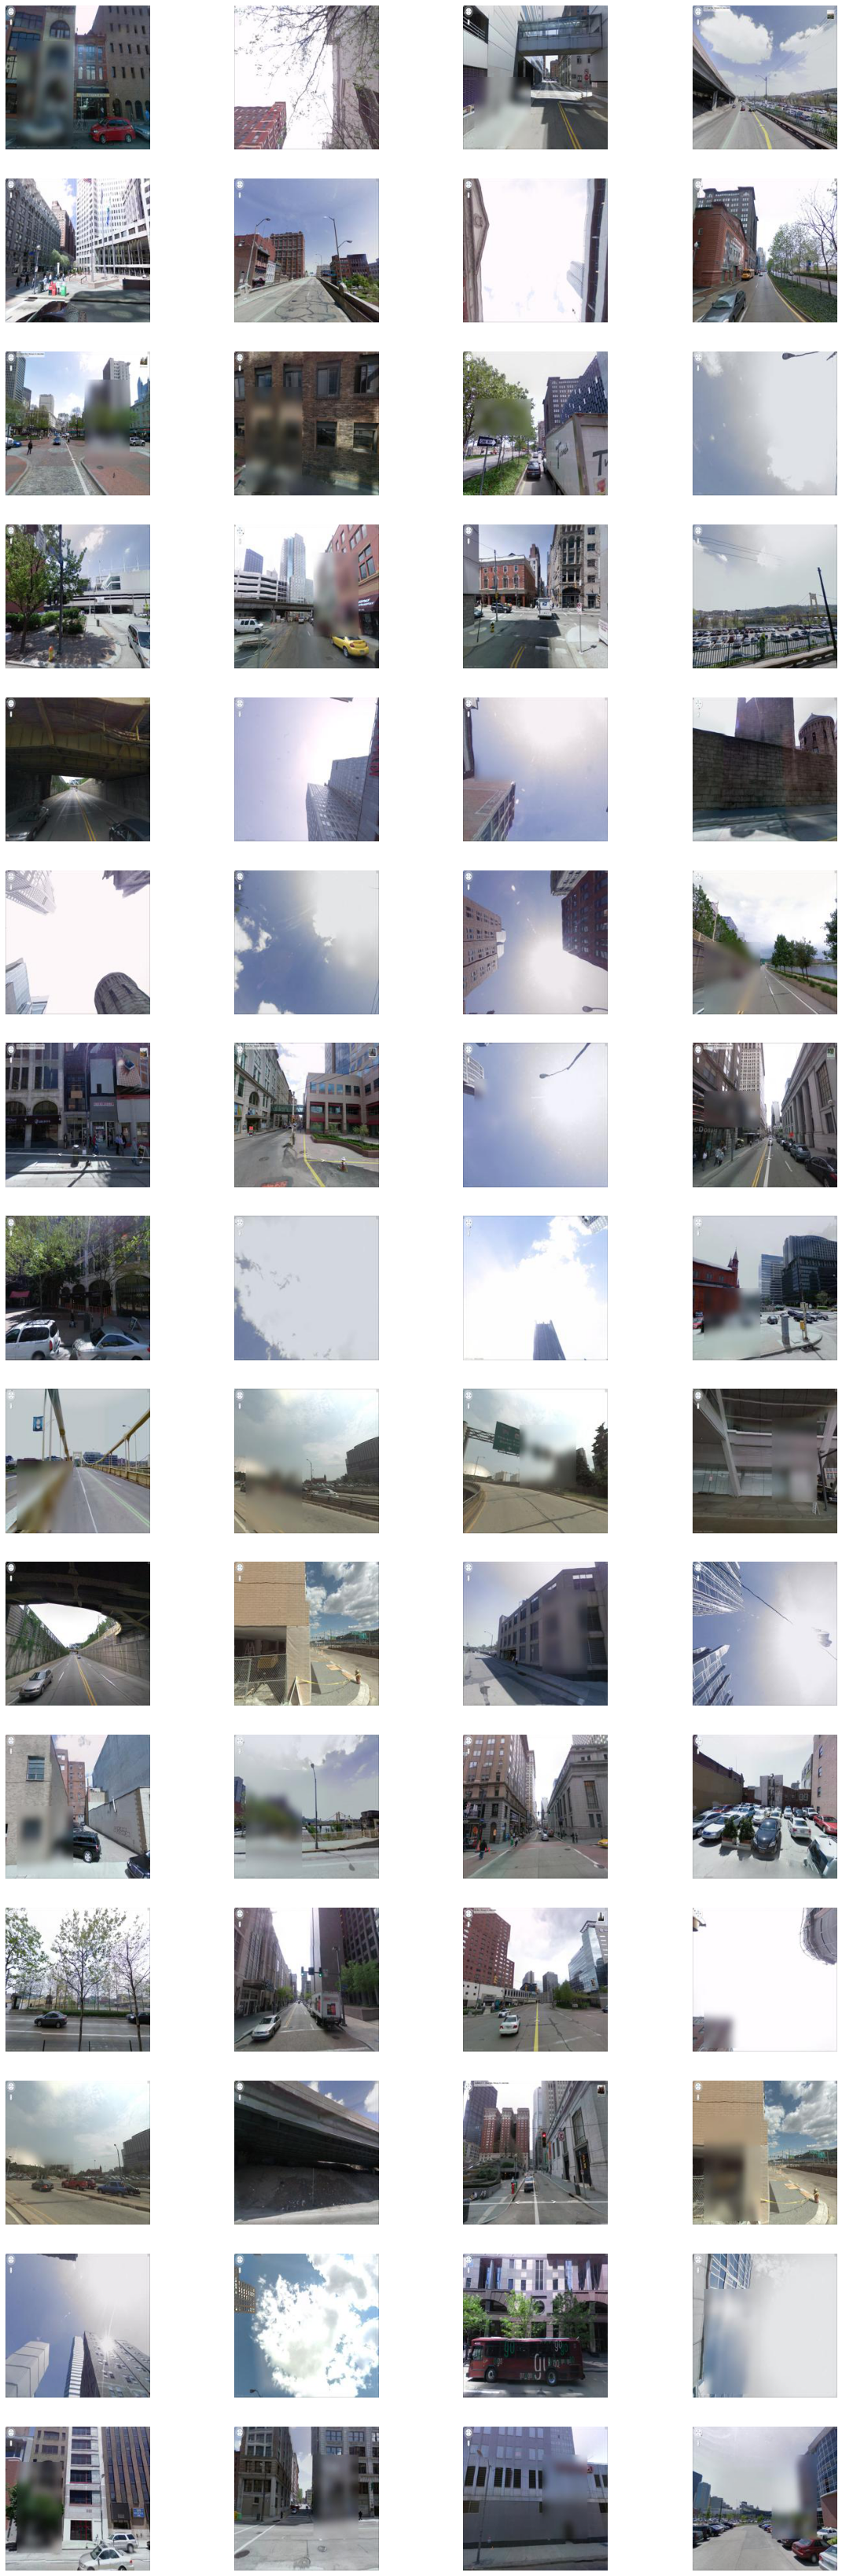

In [34]:
#images = np.load('test-label-images.npy')
#images = images[0:100]
fig = plt.figure(figsize=(20,60))
columns = 4
rows = 15
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(images[i],cmap='binary')
  plt.axis("off")
plt.show()